# Project information

I plan to perform a RNA-Seq study project using a GEO dataset for Latent Tuberculosis CD4 T-Cell response within Human. Here is the link to the accession page: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE99373. 

The organism is Homo sapiens, and the series accession ID is GSE99373. The data was collected using high throughput sequencing of CD4 T-cells from 20 subjects with latent tuberculosis infection and 19 healthy controls. I will be using the expression profiling counts that represent the transcriptomic response to the disease. 

My project plan is to first perform enrichment analysis & PCA dimensionality reduction (among other analysis), to identify candidate genes that express differential expression between the two conditions ('healthy' and 'Latent tuberculosis infection'). 

The planned steps for analysis:

1. Gene selection and filtering
2. Normalizing Counts
3. Finding differentially expressed genes (Clustering)
4. Dimensionality Reduction

### Set Up

[Ensure that `pip install pydeseq2` is run prior and `pip install umap-learn[plot]`]

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import h5py
from umap import UMAP
import scipy 
from scipy import stats
import seaborn as sns
import altair as alt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import GEOparse

In [2]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

from scipy.signal.signaltools import _centered as trim_centered

In [3]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

## Reading Counts Data and Metadata

The data containing the read counts for the samples will be read, along with some metadata.

In [4]:
# reading in the raw counts data (GSE Accession: GSE99373)
df = pd.read_excel("GSE99373_RawCounts_CD4.xlsx")
# setting it so Genes are columns and rows are samples
df = df.set_index('Transcript_ID').T
df = df.rename_axis(None, axis=1)  # removing Transcipt_ID axis name
df.head()

,MARCH1,MARC1,MARCH2,MARC2,MARCH3,MARCH4,MARCH5,MARCH6,MARCH7,MARCH8,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TU0094_CD4_HC,0,61,0,818,93,0,658,2215,2461,186,...,172,72,101,273,699,12,550,3359,499,757
TU0110_CD4_HC,3,72,0,451,98,0,363,1540,1767,161,...,88,104,62,277,588,4,430,1806,287,610
XT0082_CD4_HC,0,21,0,506,16,0,279,1377,1603,141,...,56,72,44,167,234,7,238,1488,247,514
XT0101_CD4_HC,0,18,0,892,147,0,500,2130,1961,191,...,108,195,53,245,216,8,280,2505,394,968
XT0106_CD4_HC,0,21,0,468,22,0,135,862,1210,98,...,95,72,67,170,139,1,261,1523,156,537


In [5]:
# seeing the raw count shape
print(df.shape)

(39, 21920)


We can confirm there are 39 samples (19 are healthy, 20 are latent TB). We have 21,920 genes present, which we will be filtering to ideally reduce the number of candidate genes. Prior to this step, we can read some metadata for the runs, including information on which runs are controls or not.

In [6]:
# # Reading GEO data based on accession
# gse = GEOparse.get_GEO("GSE99373")
# # View metadata associated with the dataset
# meta = gse.phenotype_data
# meta.to_csv('meta_GSE99373.csv', index=False)

In [7]:
# Reading in metadata
meta_df = pd.read_csv('meta_GSE99373.csv')
print(meta_df.shape)
meta_df.head()

(39, 35)


,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_zip/postal_code,contact_country,instrument_model,library_selection,library_source,library_strategy,relation,supplementary_file_1,series_id,data_row_count
0,TU0094_CD4_HC,GSM2643136,Public on Jun 14 2018,May 26 2017,May 15 2019,SRA,1,Cryopreserved PBMC,Homo sapiens,9606,...,92037,USA,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE99373,0
1,TU0110_CD4_HC,GSM2643137,Public on Jun 14 2018,May 26 2017,May 15 2019,SRA,1,Cryopreserved PBMC,Homo sapiens,9606,...,92037,USA,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE99373,0
2,XT0082_CD4_HC,GSM2643138,Public on Jun 14 2018,May 26 2017,May 15 2019,SRA,1,Cryopreserved PBMC,Homo sapiens,9606,...,92037,USA,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE99373,0
3,XT0101_CD4_HC,GSM2643139,Public on Jun 14 2018,May 26 2017,May 15 2019,SRA,1,Cryopreserved PBMC,Homo sapiens,9606,...,92037,USA,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE99373,0
4,XT0106_CD4_HC,GSM2643140,Public on Jun 14 2018,May 26 2017,May 15 2019,SRA,1,Cryopreserved PBMC,Homo sapiens,9606,...,92037,USA,Illumina HiSeq 2500,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,GSE99373,0


The metadata has 35 columns! Most are not going to be useful, so I will make a subset to be used. I will include 'title' to match with Sample Title, the 'geo_accession' as an ID, and 'characteristics_ch1.0.disease group' which indicated the treatment groups.

In [8]:
meta_df.columns
# Making selection
meta_subset = ['title', 'geo_accession', 'characteristics_ch1.0.disease group']
meta = meta_df[meta_subset]
# Renaming characteristics_ch1.0.disease group --> 'disease_group'
meta = meta.rename(columns={'characteristics_ch1.0.disease group':'disease_group'})

In [9]:
# Joining our two datasets
counts = df.copy().reset_index().rename(columns={'index':'title'})
counts = meta.merge(counts)
counts.head()

,title,geo_accession,disease_group,MARCH1,MARC1,MARCH2,MARC2,MARCH3,MARCH4,MARCH5,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,TU0094_CD4_HC,GSM2643136,Healthy,0,61,0,818,93,0,658,...,172,72,101,273,699,12,550,3359,499,757
1,TU0110_CD4_HC,GSM2643137,Healthy,3,72,0,451,98,0,363,...,88,104,62,277,588,4,430,1806,287,610
2,XT0082_CD4_HC,GSM2643138,Healthy,0,21,0,506,16,0,279,...,56,72,44,167,234,7,238,1488,247,514
3,XT0101_CD4_HC,GSM2643139,Healthy,0,18,0,892,147,0,500,...,108,195,53,245,216,8,280,2505,394,968
4,XT0106_CD4_HC,GSM2643140,Healthy,0,21,0,468,22,0,135,...,95,72,67,170,139,1,261,1523,156,537


## Gene Filterating

Prior to normalizing our counts, it would be advantageous to identify and select genes that impart the most information. 

From a cursory glance at the counts data, we can see a lot of zeros. Prior to converting to Log2, a small value will be added to avoid -inf errors.

In [10]:
# small value
epsilon = 0.5

# taking log2 values
counts_log2 = np.log2(df + epsilon).clip(lower = np.log2(epsilon))
counts_log2.head()

,MARCH1,MARC1,MARCH2,MARC2,MARCH3,MARCH4,MARCH5,MARCH6,MARCH7,MARCH8,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TU0094_CD4_HC,-1.000000,5.942515,-1.0,9.676839,6.546894,-1.0,9.363040,11.113417,11.265322,7.543032,...,7.430453,6.179909,6.665336,8.095397,9.450180,3.643856,9.104599,11.714031,8.964341,9.565102
TU0110_CD4_HC,1.807355,6.179909,-1.0,8.818582,6.622052,-1.0,8.505812,10.589183,10.787494,7.335390,...,6.467606,6.707359,5.965784,8.116344,9.200899,2.169925,8.749869,10.818982,8.167418,9.253847
XT0082_CD4_HC,-1.000000,4.426265,-1.0,8.984418,4.044394,-1.0,8.126704,10.427837,10.647009,7.144658,...,5.820179,6.179909,5.475733,7.388017,7.873444,2.906891,7.897845,10.539644,7.951285,9.007027
XT0101_CD4_HC,-1.000000,4.209453,-1.0,9.801708,7.204571,-1.0,8.967226,11.056976,10.937742,7.581201,...,6.761551,7.611025,5.741467,7.939579,7.758223,3.087463,8.131857,11.290883,8.623881,9.919608
XT0106_CD4_HC,-1.000000,4.426265,-1.0,8.871905,4.491853,-1.0,7.082149,9.752381,10.241387,6.622052,...,6.577429,6.179909,6.076816,7.413628,7.124121,0.584963,8.030667,10.573174,7.290019,9.070121


Now that we have the log2 transformed counts, we can try to visualize the distribution of the counts:

Text(0, 0.5, 'Frequency')

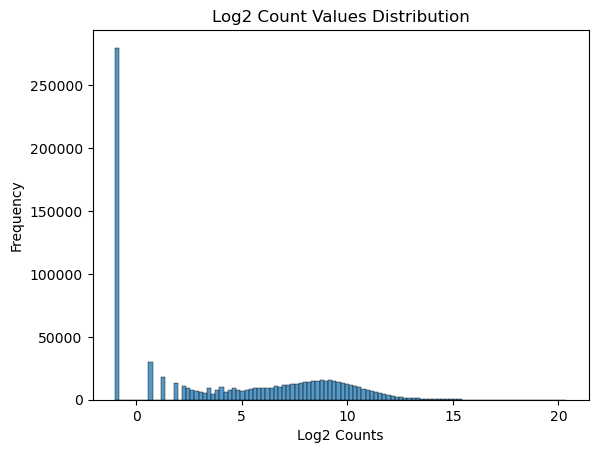

In [11]:
sns.histplot(counts_log2.values.flatten())
plt.title('Log2 Count Values Distribution')
plt.xlabel('Log2 Counts')
plt.ylabel('Frequency')

#plt.savefig('Log2CountsHistogram.png')

The histogram shows us a pretty standard distribution, where most values are -1 (0 reads). To better understand by how much we should filter our data, I will utilize a mean-variance relationship.

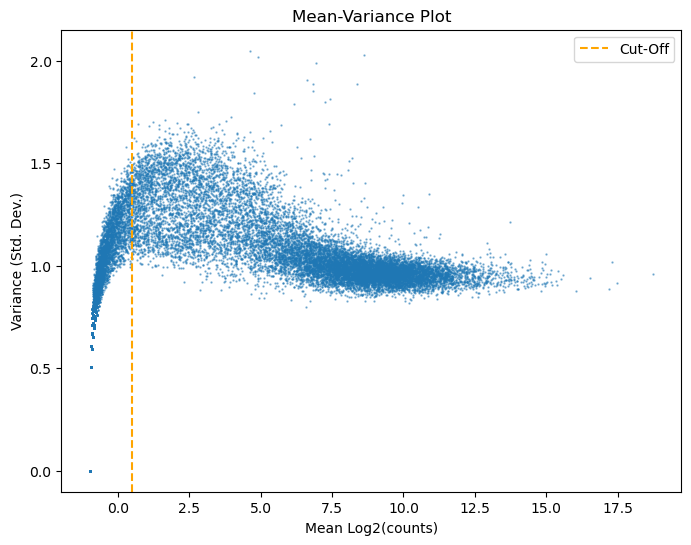

In [12]:
# Finding means per gene
means_per_gene = np.mean(counts_log2, axis=0)
# Calculating variability per gene
var_per_gene = np.sqrt(counts_log2.std())

# Plotting variability against means
fig, ax = plt.subplots(figsize=(8, 6))

# model3 = np.poly1d(np.polyfit(means_per_gene, var_per_gene, 3))
# model4 = np.poly1d(np.polyfit(means_per_gene, var_per_gene, 4))
# polyline = np.linspace(-1, 17.5)
# plt.plot(polyline, model3(polyline), color='blue')
# plt.plot(polyline, model4(polyline), color='orange')

plt.scatter(means_per_gene, var_per_gene, alpha=0.5, s=0.5)
plt.title("Mean-Variance Plot")
plt.xlabel("Mean Log2(counts)")
plt.ylabel("Variance (Std. Dev.)")
plt.axvline(0.5, linestyle='--', color='orange', label='Cut-Off')
plt.legend()
#plt.savefig('MeanVariance.png')
plt.show()

We can notice a sharp 'hook' right around the value of 0.5 along the x-axis. This indicates information loss past this point - where there is both low mean and low variance. Likely these genes are mostly undetected or would confer little meaningful in downstream analysis and could then be filtered out.

Using the threshold of 0.5, we can filter out any gene with an average expression below 0.5.

In [13]:
# Finding the mean expression per gene
means_log2 = means_per_gene.to_frame()
# applying filter
to_remove = means_log2 < 0.5
to_remove.columns = ['Log2Count']
# Keeping all False
to_keep = to_remove[~to_remove['Log2Count']]
# Getting list of genes to keep
to_keep = list(to_keep.index)
print(len(to_keep))

14419


Applying the 0.5 theshold reduces our number of genes from ~22,000 to 14,419 genes, which is a good reduction but doesn't seem to overreaching.

In [14]:
# Saving the filtered genes
filtered_df = counts_log2.copy()
filtered_df = filtered_df.loc[:, to_keep]
filtered_df.head()

,MARC1,MARC2,MARCH3,MARCH5,MARCH6,MARCH7,MARCH8,MARCH9,MARCH10,SEPT1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TU0094_CD4_HC,5.942515,9.676839,6.546894,9.363040,11.113417,11.265322,7.543032,7.854868,3.392317,11.959821,...,7.430453,6.179909,6.665336,8.095397,9.450180,3.643856,9.104599,11.714031,8.964341,9.565102
TU0110_CD4_HC,6.179909,8.818582,6.622052,8.505812,10.589183,10.787494,7.335390,7.271463,2.459432,11.499098,...,6.467606,6.707359,5.965784,8.116344,9.200899,2.169925,8.749869,10.818982,8.167418,9.253847
XT0082_CD4_HC,4.426265,8.984418,4.044394,8.126704,10.427837,10.647009,7.144658,6.276124,4.614710,11.462247,...,5.820179,6.179909,5.475733,7.388017,7.873444,2.906891,7.897845,10.539644,7.951285,9.007027
XT0101_CD4_HC,4.209453,9.801708,7.204571,8.967226,11.056976,10.937742,7.581201,6.033423,2.169925,11.852334,...,6.761551,7.611025,5.741467,7.939579,7.758223,3.087463,8.131857,11.290883,8.623881,9.919608
XT0106_CD4_HC,4.426265,8.871905,4.491853,7.082149,9.752381,10.241387,6.622052,6.451211,2.906891,11.212192,...,6.577429,6.179909,6.076816,7.413628,7.124121,0.584963,8.030667,10.573174,7.290019,9.070121


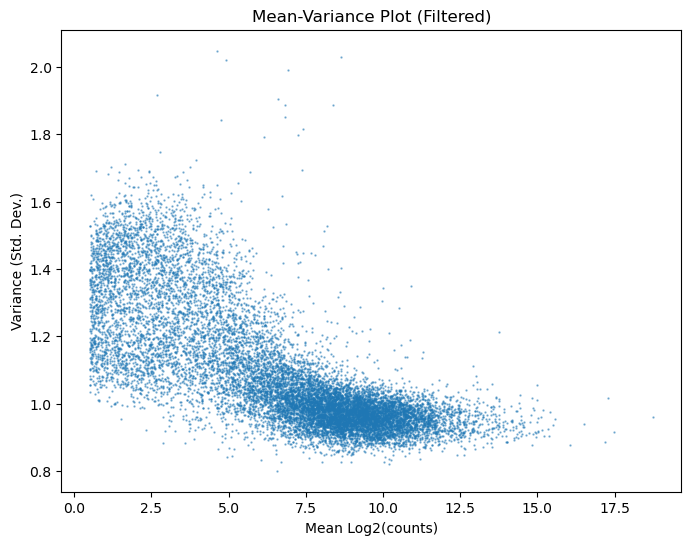

In [15]:
# Plotting the filtered subset of genes
fig, ax = plt.subplots(figsize=(8, 6))
# Only using filtered_df
plt.scatter(np.mean(filtered_df, axis=0), np.sqrt(filtered_df.std()), alpha=0.5, s=0.5)
plt.title("Mean-Variance Plot (Filtered)")
plt.xlabel("Mean Log2(counts)")
plt.ylabel("Variance (Std. Dev.)")
plt.show()

We can see that after applying our filter, there are no genes with low mean and low variance both remaining at the left tail end. Now we can apply normalization to this smaller subset to better control for differences in samples sequence reads. 

DeSeq2 will be used to normalize the expression counts, which utilizes a Median of Ratios normalization methodology. 

## Normalization

In [16]:
filtered_counts = counts.loc[:, 'MARCH1':]
filtered_counts = filtered_counts.loc[:, to_keep]
filtered_counts.index = meta['title']  # setting index to be sample title
filtered_counts.shape

(39, 14419)

In [17]:
filtered_counts.head()

,MARC1,MARC2,MARCH3,MARCH5,MARCH6,MARCH7,MARCH8,MARCH9,MARCH10,SEPT1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
title,,,,,,,,,,,,,,,,,,,,,
TU0094_CD4_HC,61,818,93,658,2215,2461,186,231,10,3983,...,172,72,101,273,699,12,550,3359,499,757
TU0110_CD4_HC,72,451,98,363,1540,1767,161,154,5,2894,...,88,104,62,277,588,4,430,1806,287,610
XT0082_CD4_HC,21,506,16,279,1377,1603,141,77,24,2821,...,56,72,44,167,234,7,238,1488,247,514
XT0101_CD4_HC,18,892,147,500,2130,1961,191,65,4,3697,...,108,195,53,245,216,8,280,2505,394,968
XT0106_CD4_HC,21,468,22,135,862,1210,98,87,7,2372,...,95,72,67,170,139,1,261,1523,156,537


In [18]:
# setting index to be title
meta_copy = meta.copy()
meta_copy.index = meta_copy['title']
meta_copy['condition'] = ['Healthy' if x == 'Healthy' else 'TB' for x in meta_copy['disease_group']]
meta_copy.head()

,title,geo_accession,disease_group,condition
title,,,,
TU0094_CD4_HC,TU0094_CD4_HC,GSM2643136,Healthy,Healthy
TU0110_CD4_HC,TU0110_CD4_HC,GSM2643137,Healthy,Healthy
XT0082_CD4_HC,XT0082_CD4_HC,GSM2643138,Healthy,Healthy
XT0101_CD4_HC,XT0101_CD4_HC,GSM2643139,Healthy,Healthy
XT0106_CD4_HC,XT0106_CD4_HC,GSM2643140,Healthy,Healthy


Note, KeyError occurs in `DeseqStats()` when using disease_group likely due to use of space in strings for Latent TB, so a copy column named disease_group was used to bypass this KeyError.

In [19]:
# Runing the DeSeq2 model fit
dds = DeseqDataSet(counts = filtered_counts, clinical = meta_copy, design_factors = "condition")
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.55 seconds.

Fitting dispersion trend curve...
... done in 2.40 seconds.

Fitting MAP dispersions...
... done in 2.98 seconds.

Fitting LFCs...
... done in 1.58 seconds.

Refitting 95 outliers.

Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.06 seconds.



In [20]:
# Calculating statistics and showing summary
deseq_stats = DeseqStats(dds, alpha=0.05)
deseq_stats.summary()

Running Wald tests...
... done in 0.58 seconds.

Log2 fold change & Wald test p-value: condition TB vs Healthy


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MARC1,21.923843,0.358751,0.473132,0.758246,0.448304,0.654748
MARC2,665.766184,-0.056635,0.102725,-0.551330,0.581407,0.760186
MARCH3,48.300358,-0.727886,0.276903,-2.628672,0.008572,0.057864
MARCH5,441.482079,-0.147102,0.092846,-1.584379,0.113108,0.290084
MARCH6,1373.411482,0.120620,0.119700,1.007687,0.313605,0.533311
...,...,...,...,...,...,...
ZYG11A,6.259223,0.914750,0.355119,2.575896,0.009998,NaN
ZYG11B,359.611925,0.010619,0.128923,0.082368,0.934354,0.968578
ZYX,2889.086163,-0.119258,0.105481,-1.130615,0.258217,0.476118
ZZEF1,326.592644,0.691044,0.157090,4.399034,0.000011,0.000925


In [21]:
results = deseq_stats.results_df
results.isna().sum()  # should I drop these NaN padj values? Can I use the unadjusted pvalues instead?

baseMean             0
log2FoldChange       0
lfcSE                0
stat                 0
pvalue               0
padj              3355
dtype: int64

To correct for the NaN values that appear in the adjusted p-value, I manually applied the Benjamin-Hochberg FDR correction. These values will be used to choose for significant genes.

In [22]:
import statsmodels.stats.multitest as smm
adjusted = smm.multipletests(results['pvalue'], alpha=0.05, method='fdr_bh')

In [23]:
results['bh_adj'] = adjusted[1]
results['bh_adj'].isna().sum()

0

In [24]:
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bh_adj
MARC1,21.923843,0.358751,0.473132,0.758246,0.448304,0.654748,0.696534
MARC2,665.766184,-0.056635,0.102725,-0.551330,0.581407,0.760186,0.790953
MARCH3,48.300358,-0.727886,0.276903,-2.628672,0.008572,0.057864,0.070854
MARCH5,441.482079,-0.147102,0.092846,-1.584379,0.113108,0.290084,0.335162
MARCH6,1373.411482,0.120620,0.119700,1.007687,0.313605,0.533311,0.582942
...,...,...,...,...,...,...,...
ZYG11A,6.259223,0.914750,0.355119,2.575896,0.009998,NaN,0.077632
ZYG11B,359.611925,0.010619,0.128923,0.082368,0.934354,0.968578,0.973759
ZYX,2889.086163,-0.119258,0.105481,-1.130615,0.258217,0.476118,0.527719
ZZEF1,326.592644,0.691044,0.157090,4.399034,0.000011,0.000925,0.001188


In [25]:
results.sort_values('log2FoldChange', ascending=False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bh_adj
SCGB3A1,12.310035,3.569624,0.805230,4.433051,0.000009,NaN,0.001088
ANPEP,5.629526,3.461461,0.983342,3.520101,0.000431,NaN,0.011684
NTSR1,4.971398,3.410616,0.968821,3.520378,0.000431,NaN,0.011684
C21orf15,5.019257,3.060152,0.744545,4.110096,0.000040,NaN,0.002755
PID1,3.617574,2.842572,0.964403,2.947495,0.003204,NaN,0.038771
...,...,...,...,...,...,...,...
FAM154A,3.455469,-1.908460,1.039079,-1.836684,0.066257,NaN,0.244024
NLRC4,4.059963,-2.164608,0.788441,-2.745429,0.006043,NaN,0.057060
ADAMTS1,6.014754,-2.176871,0.994746,-2.188369,0.028643,NaN,0.149044
CH25H,6.039830,-2.770117,0.839274,-3.300611,0.000965,NaN,0.019428


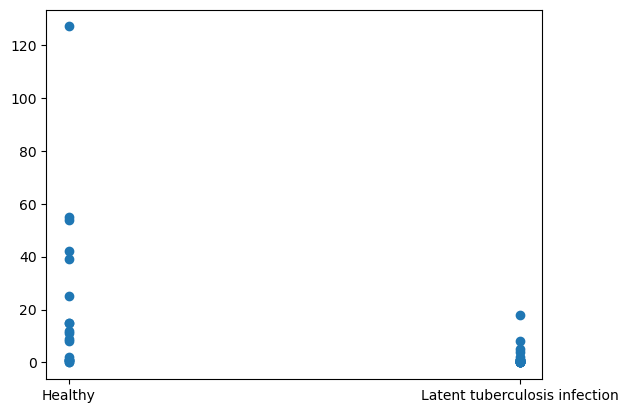

In [26]:
# plotting ADARB2
plt.scatter(counts['disease_group'], counts['ADARB2'])

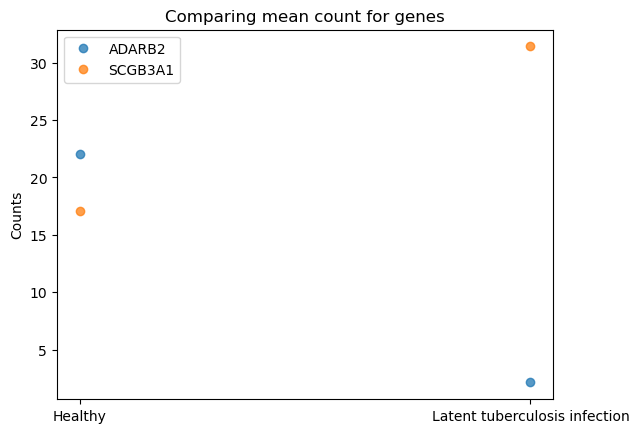

In [27]:
plt.plot(counts.groupby('disease_group')['ADARB2'].mean(), 'o', alpha = 0.75, label='ADARB2')
plt.plot(counts.groupby('disease_group')['SCGB3A1'].mean(), 'o', alpha = 0.75, label='SCGB3A1')
plt.title("Comparing mean count for genes")
plt.ylabel("Counts")
plt.legend()
plt.show()

A large negative fold change is associated with higher expression in the Healthy cells, whereas a positive fold change implies higher expression in the TB cells. ADARB2 had the most negative log2fold change, and we can see that there is a higher expression in the Healthy cells. This matches with SCGB3A1 which had the largest log2fold change, and has higher expression in Latent TB cells.

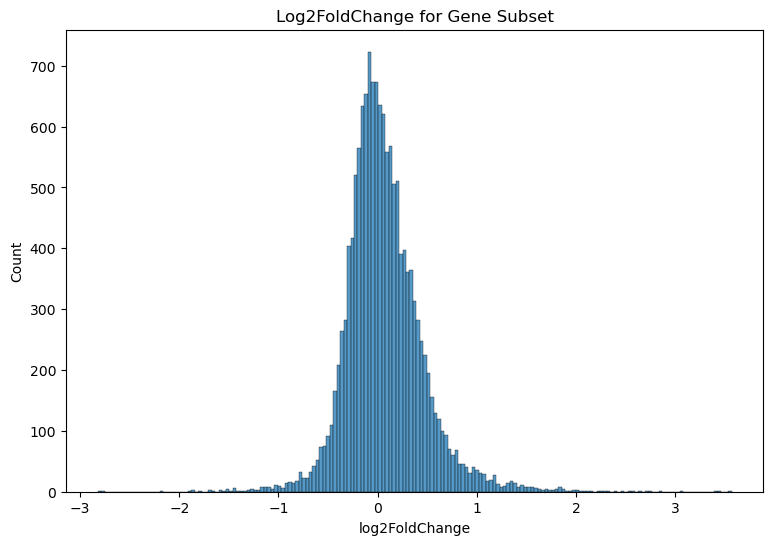

In [28]:
# Plotting the filtered subset of genes
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(results['log2FoldChange'])
plt.title("Log2FoldChange for Gene Subset")
#plt.savefig('FoldChangeDistribution.png')

Choosing an absolute log change value of 1 would be a good threshold to select for differentially expressed genes. A log2FoldChange of 1 would mean that there is at least a double expression change between the two conditions.

In [29]:
# Filtering by adj p < 0.05 and log fold-change > 1
diff_exp_genes = results[(results['bh_adj'] < 0.05) & (abs(results['log2FoldChange']) > 1)]
print('Number of genes:', diff_exp_genes.shape[0])

diff_exp_genes

Number of genes: 96


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bh_adj
ADARB2,10.319269,-2.823596,0.725326,-3.892863,0.000099,NaN,0.004838
AKAP5,17.219654,1.029526,0.305379,3.371309,0.000748,NaN,0.016698
ANGPTL6,8.934689,1.508795,0.532930,2.831130,0.004638,NaN,0.048445
ANPEP,5.629526,3.461461,0.983342,3.520101,0.000431,NaN,0.011684
AURKAPS1,9.838668,1.811915,0.547004,3.312438,0.000925,NaN,0.018916
...,...,...,...,...,...,...,...
ZNF225,36.401663,-1.150269,0.318828,-3.607803,0.000309,0.007660,0.009680
ZNF594,16.851001,1.254755,0.388891,3.226496,0.001253,NaN,0.022392
ZNF618,15.273898,-1.529536,0.413964,-3.694852,0.000220,NaN,0.007931
ZNF787,11.725909,1.125876,0.315479,3.568785,0.000359,NaN,0.010486


After using a threshold of log2 fold change value of 1, and a adjusted p-value of less than 0.05, I have a subset of 96 genes remaining. The next step is then to perform clustering and correlations, followed by PCA. However prior to that, I will use the [ShinyGo](http://bioinformatics.sdstate.edu/go/) tool to identify any signifcantly enriched KEGG pathways when using only our differenially expressed genes.

In [30]:
# Exporting gene names to a CSV for use in ShinyGo
deg = pd.DataFrame(diff_exp_genes.index)
deg.to_csv("LatentTB_DEG.csv", index=False, header=False)

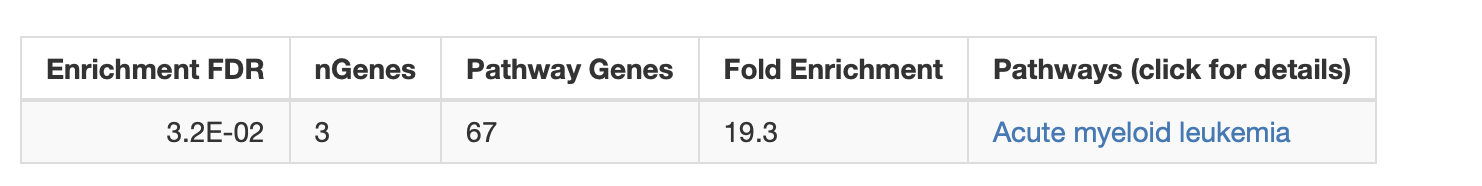

There was only one signifcantly enriched pathway from the list of differentially expressed genes identified in the RNASeq pipeline. We can see from ShinyGo that the Acute Myeloid Leukemia pathway had a fold enrichment of 19.3 with a FDR rate of 0.032. Perhaps the selection process was a little too stringent.

Although this pathway is mainly associated with the condition of Acute Myeloid Leukemia, this could imply some crossover in similar genes for Latent Tuberculosis. Potentially testing drugs that have been developed to treat Acute Myeloid Leukemia targetting this pathways could have some therapeutic power for treating latent TB. To get some more details on specific genes driving variance, PCA can be used to identify key genes of interest.

## Clustering

Prior to PCA, I will utilize a clustermap to identify any interesting groupings among the genes I selected

In [31]:
deg = diff_exp_genes.index.tolist()

# Extracting the log2 expression values of only these genes
epsilon = 0.5
log2_deg = np.log2(filtered_counts.loc[:, deg] + epsilon).clip(lower=np.log2(epsilon))

In [32]:
# Renaming samples to include condition
samples_labeled = meta_copy['condition'] + "_" + meta_copy['title']
samples_labeled = samples_labeled.to_list()
log2_deg.index = samples_labeled
log2_deg.head()

,ADARB2,AKAP5,ANGPTL6,ANPEP,AURKAPS1,B3GALT2,BAI1,C21orf15,C5orf42,CCDC39,...,TMOD2,TUB,USP32P1,UTS2,ZNF189,ZNF225,ZNF594,ZNF618,ZNF787,ZNF883
Healthy_TU0094_CD4_HC,3.523562,5.022368,4.554589,-1.000000,3.392317,5.965784,0.584963,1.321928,7.519636,5.794416,...,7.413628,4.781360,2.459432,8.726218,5.845490,6.238405,4.554589,4.882643,4.044394,6.276124
Healthy_TU0110_CD4_HC,0.584963,4.044394,2.459432,2.700440,2.906891,4.672425,1.807355,1.321928,6.707359,5.228819,...,7.071462,3.643856,6.055282,2.906891,5.629357,4.614710,4.285402,3.954196,2.906891,5.714246
Healthy_XT0082_CD4_HC,3.954196,3.087463,3.087463,0.584963,1.807355,4.044394,1.321928,0.584963,6.876517,4.491853,...,6.294621,1.807355,4.977280,4.554589,4.727920,4.426265,2.459432,2.906891,2.169925,5.741467
Healthy_XT0101_CD4_HC,3.087463,4.426265,2.169925,-1.000000,2.459432,5.266787,1.807355,-1.000000,6.665336,5.442943,...,6.912889,3.523562,4.832890,4.930737,4.977280,5.741467,4.882643,4.044394,1.807355,2.906891
Healthy_XT0106_CD4_HC,5.409391,2.906891,1.321928,-1.000000,-1.000000,3.523562,-1.000000,-1.000000,5.768184,2.700440,...,5.442943,3.087463,2.906891,3.392317,4.882643,5.507795,1.807355,4.044394,0.584963,5.599913


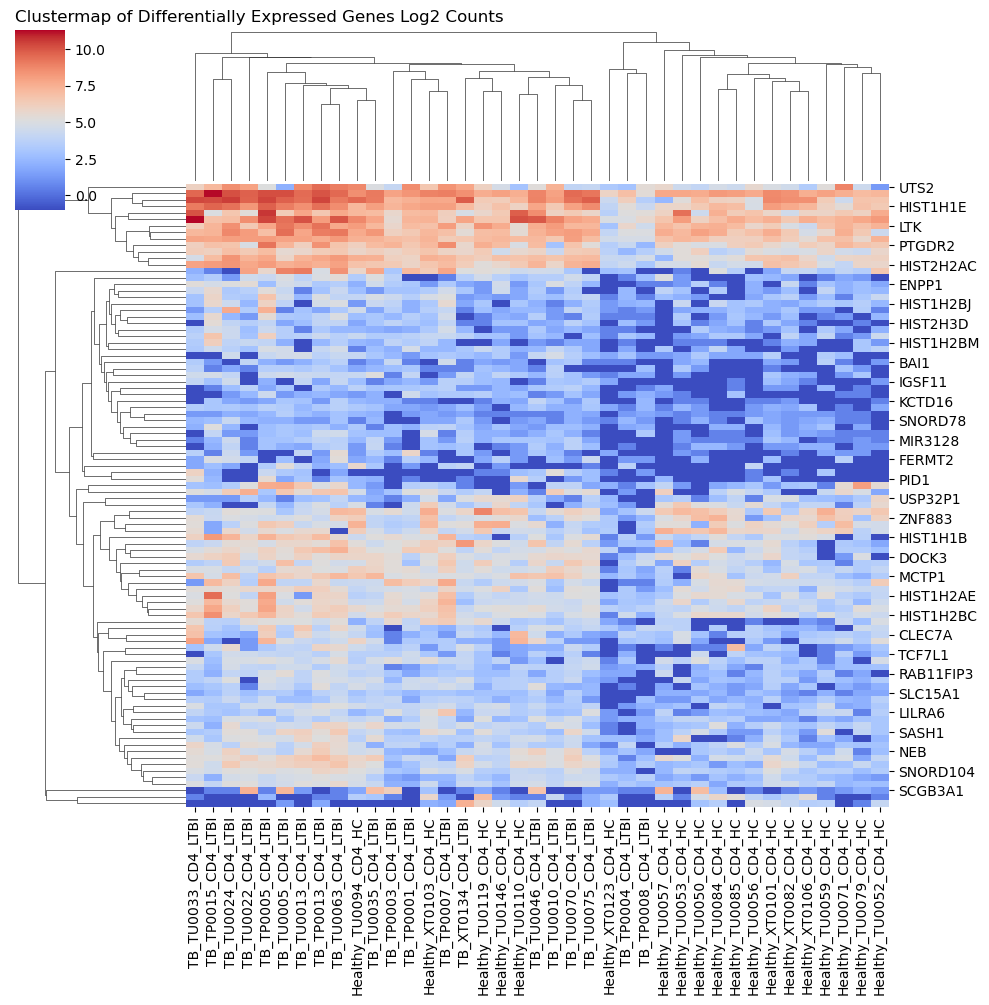

In [33]:
# Viewing a clustermap
sns.clustermap(log2_deg.T, cmap = 'coolwarm')
plt.title("Clustermap of Differentially Expressed Genes Log2 Counts", loc='left')
#plt.savefig('Clustergram.png')
plt.show()

Figure Observations:

- We see some expected clustering for samples (ie: the healthy samples are generally clustered together vs. TB), however notably some of samples don't do this as cleanly. The sample TU0094 (Healthy) for example clusters more with the Latent TB sampels. Similarly the samples TUO119/146/110 cluster together but seem to fall more closely to the TB samples.
- In terms of genes, we can see that a small group of genes with really high log2 counts cluster together (in red) whereas most genes have medium to lower log2 counts (blue)
- From this clustermap there is a good chance that PCA may be useful in findings clusters of interesting genes

## Principal Component Analysis

I'll perform PCA on the log2counts for the genes of interest as done above

In [34]:
# Creating a copy of the meta dataset for PCA use
meta_pca = meta_copy.copy()
# Dropping redundant info
meta_pca.rename(columns={"title": "sample_title"}, inplace=True)
meta_pca.reset_index(drop=True, inplace=True)
meta_pca = meta_pca.drop('disease_group', axis=1)

In [35]:
# Applying a standard scalar to standardize values
tb_scaled = StandardScaler().fit_transform(log2_deg)

# Applying PCA 
tb_pca = PCA().fit(tb_scaled)
tb_pca_data = tb_pca.transform(tb_scaled)

[0.34903864 0.0737482  0.06155922 0.04998662 0.03976054 0.03541495
 0.03109347 0.02935875 0.02558518 0.02465677]


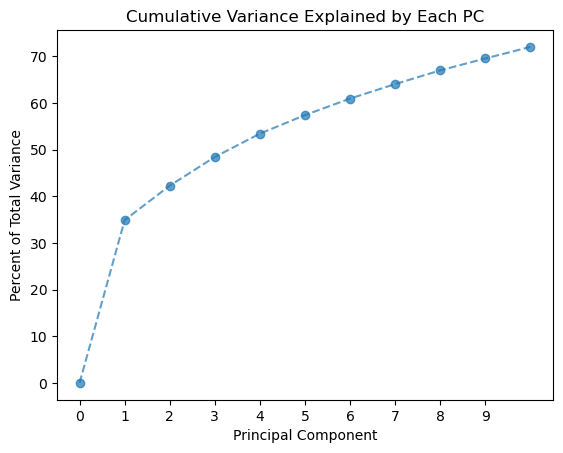

In [36]:
# Checking the variance explained by first 10 PCs
print(tb_pca.explained_variance_ratio_[:10])

# Plotting to visualize the numbers
explained_variances = tb_pca.explained_variance_ratio_[:10] * 100
explained_variances = np.hstack([np.array([0]), explained_variances]) # Adding a zero
plt.plot(explained_variances.cumsum(), 'o', linestyle='--', alpha = 0.7)

plt.title("Cumulative Variance Explained by Each PC")
plt.ylabel("Percent of Total Variance")
plt.xlabel("Principal Component")
plt.xticks(np.arange(0, 10))
#plt.savefig('PCA_Explained.png')
plt.show()

We can see that the first principal component captures by far the most variance (over 1/3 of the total variance in the dataset). From then we see a small gradual plateau, with no sharp jumps. The first 4 PC's capture over 50% of the total variance.

In [37]:
# Appending of pca data
pca_df = meta_pca.copy()
pca_df['PC1'] = tb_pca_data[:, 0] # Grabbing first column
pca_df['PC2'] = tb_pca_data[:, 1] # Grabbing second column
pca_df['PC3'] = tb_pca_data[:, 2] # Grabbing third column
pca_df['PC4'] = tb_pca_data[:, 3] # Grabbing fourth column

pca_df.head()

,sample_title,geo_accession,condition,PC1,PC2,PC3,PC4
0,TU0094_CD4_HC,GSM2643136,Healthy,-4.665591,1.187758,-2.159170,-0.943770
1,TU0110_CD4_HC,GSM2643137,Healthy,-0.585646,2.625205,-3.581123,1.856069
2,XT0082_CD4_HC,GSM2643138,Healthy,1.864372,0.162804,1.623302,-1.958548
3,XT0101_CD4_HC,GSM2643139,Healthy,0.113425,1.470660,-1.241516,-2.509865
4,XT0106_CD4_HC,GSM2643140,Healthy,6.304031,-0.011226,-0.567638,-0.220658


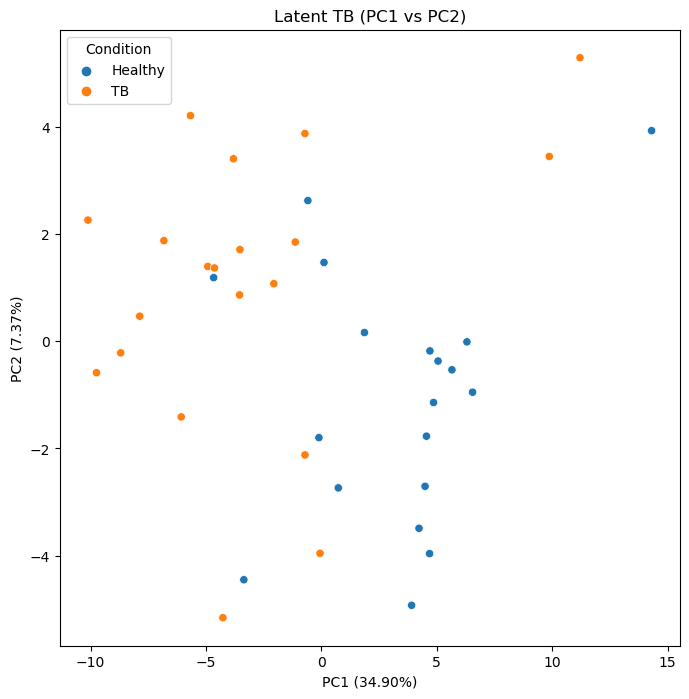

In [38]:
# Plotting first two PCs
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)

# Plotting PC1 vs PC2
sns.scatterplot(pca_df, x='PC1', y='PC2', hue='condition')

# Setting labels
ax.set_xlabel('PC1 ({0:.2f}%)'.format(tb_pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC2 ({0:.2f}%)'.format(tb_pca.explained_variance_ratio_[1]*100))
plt.title("Latent TB (PC1 vs PC2)")
plt.legend(title='Condition')
#plt.savefig('PC1vsPC2.png')
plt.show()

Just looking at PC1 and PC2 we can see some differentiation between then healthy and TB samples. We generally can see Healthy samples cluster toegther in the center, wheread the TB samples appear more towards the left side of the plot.

In [39]:
# plotting the chart pc1 vs pc2
pc_plot = alt.Chart(pca_df, title="PC1 vs PC2 Plot").mark_point().encode(
    x = "PC1",
    y = "PC2",
    color = "condition"
)

# plotting the chart pc2 vs pc3
pc_plot2 = alt.Chart(pca_df, title="PC2 vs PC3 Plot").mark_point().encode(
    x = "PC2",
    y = "PC3",
    color = "condition"
)
# plotting the chart pc3 vs pc4
pc_plot3 = alt.Chart(pca_df, title="PC3 vs PC4 Plot").mark_point().encode(
    x = "PC3",
    y = "PC4",
    color = "condition"
)

(pc_plot | pc_plot2) & pc_plot3

alt.VConcatChart(...)

Visualizing mutliple PC plots PC1 vs PC2 seemed to have the clearest distinction between Latent TB and Healthy samples. On the PC1 and PC2 plot, I will overlay the genes that contribute most to each direction.

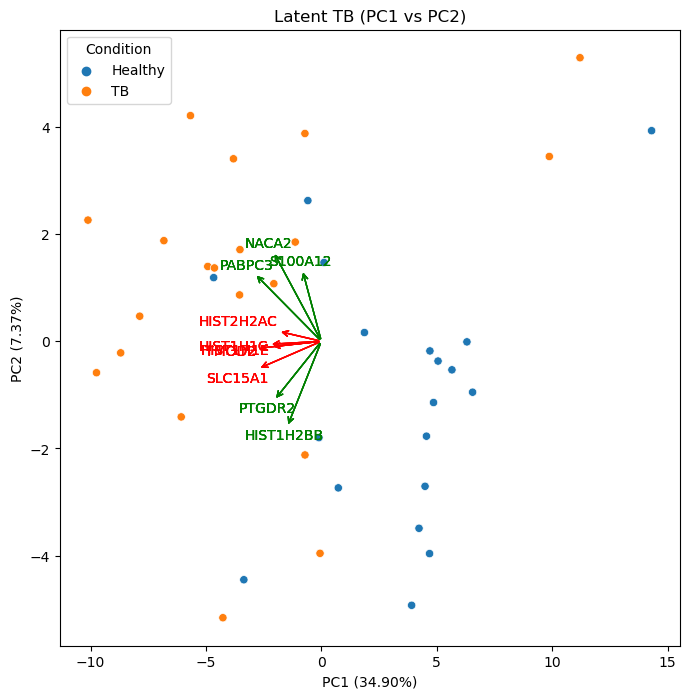

In [46]:
# Getting PC1 values and multiplying by explained variance
pc1_loading = tb_pca.components_[0, :].T
pc1_weighted_loading = pc1_loading * tb_pca.explained_variance_[0]

# Retrieving gene names
gene_names = deg

# Getting top 5 genes
top_genes_idx = np.argsort(np.abs(pc1_weighted_loading))[-5:]
pc1_top_genes = []
for gene_id in top_genes_idx:
    pc1_top_genes.append(gene_names[gene_id])
    # start at 0,0 (middle)
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='red'), color='red') # add direction
    
# Repeating for pc2
pc2_loading = tb_pca.components_[1, :].T
pc2_weighted_loading = pc2_loading * tb_pca.explained_variance_[1]
top_genes_idx = np.argsort(np.abs(pc2_weighted_loading))[-5:]
pc2_top_genes = []
for gene_id in top_genes_idx:
    pc2_top_genes.append(gene_names[gene_id])
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='green'), color='green') # add direction
#fig.savefig('PC_directions.png')
fig

In [47]:
pc2_top_genes

['PTGDR2', 'PABPC3', 'S100A12', 'NACA2', 'HIST1H2BB']

We can see that the top 5 genes that contribute most to PC1 all pull in the same direction (colored in red). For PC2 (colored in green), there is less alignment. The genes that contribute most to PC1 are SLC15A1, TMOD2, and HIST1H1E, HIST1H1C, HIST2H2AC. For PC2 the largest contributing genes are PTGDR2, PABPC3, S100A12, NACA2, HIST1H2BB. 

Since these genes are large contirbutors to observed variance, they would be top candidate genes for further experiments in being early identifiers for latent tubercolosis.

## Disease Predictive Modelling 

Having identified an enriched pathways, and some top genes of interest for further analysis, I want to also start the process of creative predictive models that use the log2 count values of the 96 differentially expressed genes to predict liklihood of a sample being healthy or having latent TB.

Since I am only working with 39 samples, this approach is meant to give a better understanding to what models may be best at predicting chance of disease rather than build a fully robust model. I will utilize cross validation to seperate training and testing data from my 39 samples. Since the dataset is really small and 'wide' (using 39 samples, and 96 columns) I will compare Naive Bayes, SVM, and K-NN which all generally perform better with smaller sample sizes than models such as Neural Networks or Decision Trees.

Although there are existing options to test patients for latent TB, a predicitive model that is accurate in differentiating samples would be beneficial in drug development and testing, potentially lowering costs associated with checking treatments efficacy.

In [48]:
# preparing our dataframes for modelling
X_values = log2_deg.copy() 
labels = meta_pca['condition']

In [49]:
# using 5 fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold

# using 5 folds
cv = StratifiedKFold(n_splits=5)

In [50]:
from sklearn.naive_bayes import GaussianNB

nb_score = 0
naivebayes = GaussianNB()
results = cross_validate(naivebayes, X_values.values, labels.values, cv = cv, return_train_score=True)
nb_score = results['test_score'].mean()
print("Average Naive Bayes Test Accuracy:", nb_score)

Average Naive Bayes Test Accuracy: 0.7392857142857142


In [51]:
# Making a NB Model trained on all the data
model_results_df = pd.DataFrame()
model_results_df['nb_test'] = results['test_score']
model_results_df

,nb_test
0,0.625000
1,0.875000
2,0.875000
3,0.750000
4,0.571429


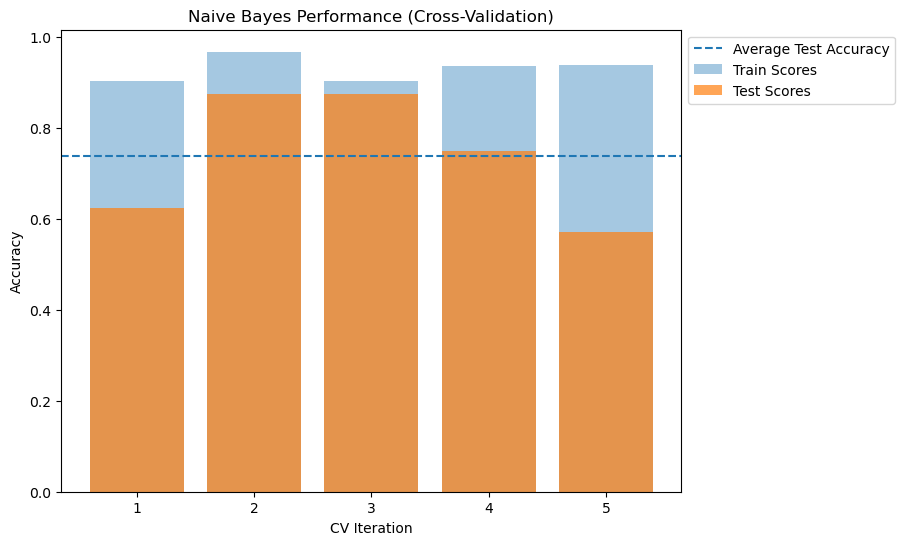

In [52]:
plt.figure(figsize=[8, 6])
plt.bar(np.arange(1, 6), results['train_score'], alpha = 0.4, label = 'Train Scores')
plt.bar(np.arange(1, 6), results['test_score'], alpha = 0.7, label = 'Test Scores')
plt.title("Naive Bayes Performance (Cross-Validation)")
plt.axhline(nb_score, linestyle='--', label='Average Test Accuracy')
plt.xlabel("CV Iteration")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('NB_cv.png')
plt.show()

From the cross validation results, Naive Bayes is performing at around 74% test accuracy, which is pretty good. We can see that training scores are much higher typically, showing a slight tendency to over-fit. Lets compare this model to SVM and K-NN:

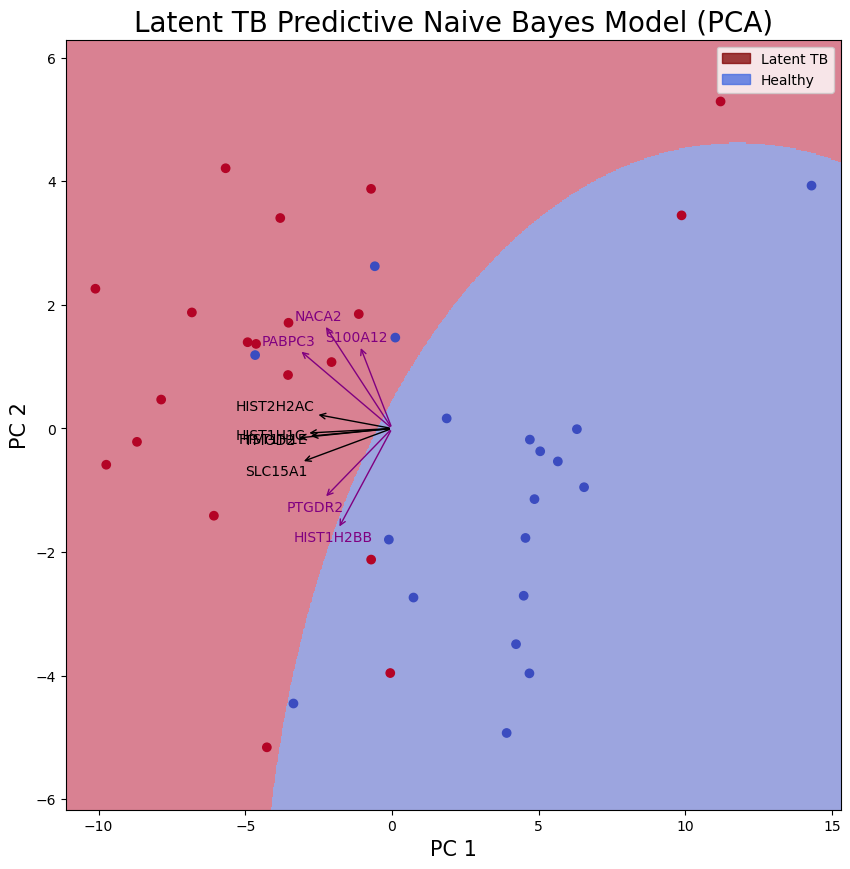

In [66]:
import matplotlib.patches as mpatches
pca = PCA(n_components = 2)
pca.fit(tb_scaled)
pcs = pca.transform(tb_scaled)
X = pcs
h = .02  # step size in the mesh

nb_model = naivebayes.fit(X, labels)


y = [0 if x == 'Healthy' else 1 for x in labels]
# predict the classification probabilities on a grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = nb_model.predict(np.c_[xx.ravel(), yy.ravel()])


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, zorder=2, cmap='coolwarm')
z = Z.reshape(xx.shape)
z = (z == 'Healthy').astype(int)

red_patch = mpatches.Patch(color='maroon', label='Latent TB',
                           alpha=0.75)
blue_patch = mpatches.Patch(color='royalblue', label='Healthy',
                            alpha=0.75)
plt.legend(handles=[red_patch, blue_patch])
plt.pcolormesh(xx, yy, z, cmap='coolwarm_r', alpha = 0.5)

plt.xlabel("PC 1", fontsize = 15)
plt.ylabel("PC 2", fontsize = 15)
plt.title("Latent TB Predictive Naive Bayes Model (PCA)", fontsize = 20)

# Getting top 5 genes
top_genes_idx = np.argsort(np.abs(pc1_weighted_loading))[-5:]
pc1_top_genes = []
for gene_id in top_genes_idx:
    pc1_top_genes.append(gene_names[gene_id])
    # start at 0,0 (middle)
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='black'), color='black') # add direction
    
# Repeating for pc2
pc2_loading = tb_pca.components_[1, :].T
pc2_weighted_loading = pc2_loading * tb_pca.explained_variance_[1]
top_genes_idx = np.argsort(np.abs(pc2_weighted_loading))[-5:]
pc2_top_genes = []
for gene_id in top_genes_idx:
    pc2_top_genes.append(gene_names[gene_id])
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='purple'), color='purple') # add direction
#plt.savefig('NB_pca.png')
plt.show()

In [54]:
from sklearn.svm import SVC

svm_score = 0
svm_model = SVC(kernel='rbf')
results = cross_validate(svm_model, X_values.values, labels.values, cv = cv, return_train_score=True)
svm_score = results['test_score'].mean()
print("Average Naive Bayes Test Accuracy:", svm_score)

Average Naive Bayes Test Accuracy: 0.8464285714285713


In [55]:
model_results_df['svm_test'] = results['test_score']

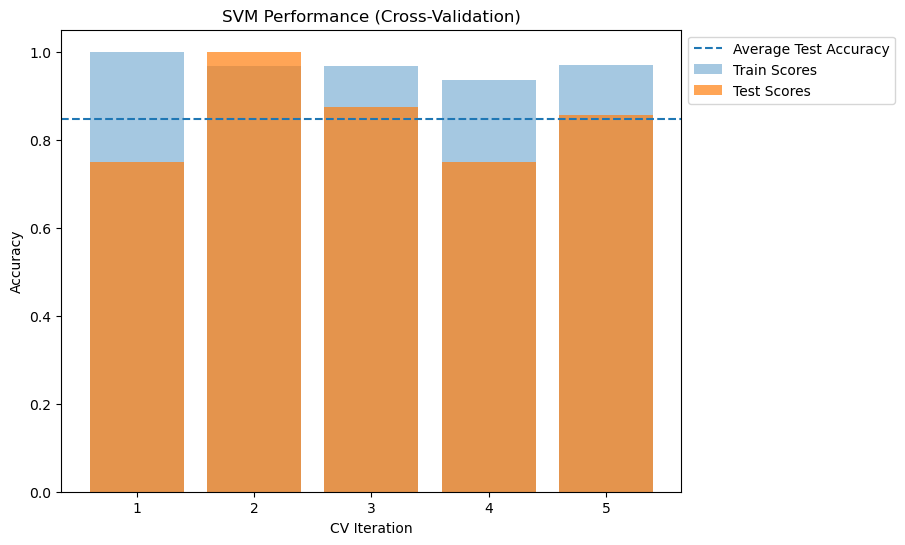

In [56]:
plt.figure(figsize=[8, 6])
plt.bar(np.arange(1, 6), results['train_score'], alpha = 0.4, label = 'Train Scores')
plt.bar(np.arange(1, 6), results['test_score'], alpha = 0.7, label = 'Test Scores')
plt.title("SVM Performance (Cross-Validation)")
plt.axhline(svm_score, linestyle='--', label='Average Test Accuracy')
plt.xlabel("CV Iteration")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('svm_cv.png')
plt.show()

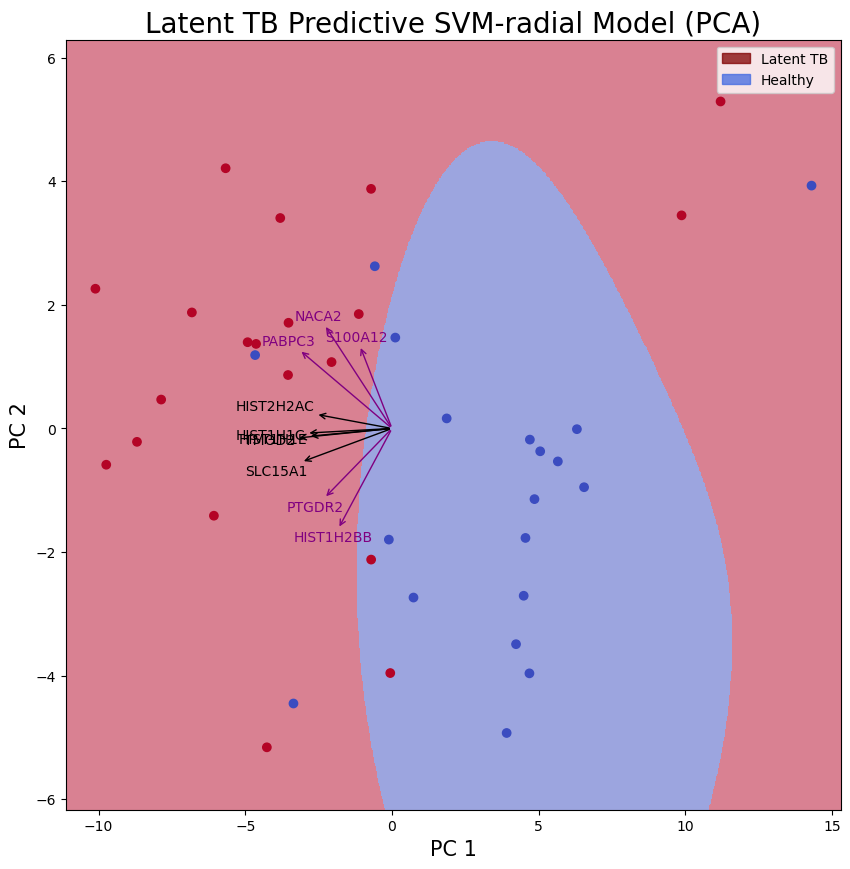

In [68]:
pca = PCA(n_components = 2)
pca.fit(tb_scaled)
pcs = pca.transform(tb_scaled)
X = pcs
h = .02  # step size in the mesh

svm_model = SVC(kernel='rbf')
svm_model = svm_model.fit(X, labels)


y = [0 if x == 'Healthy' else 1 for x in labels]
# predict the classification probabilities on a grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, zorder=2, cmap='coolwarm')
z = Z.reshape(xx.shape)
z = (z == 'Healthy').astype(int)

red_patch = mpatches.Patch(color='maroon', label='Latent TB',
                           alpha=0.75)
blue_patch = mpatches.Patch(color='royalblue', label='Healthy',
                            alpha=0.75)
plt.legend(handles=[red_patch, blue_patch])
plt.pcolormesh(xx, yy, z, cmap='coolwarm_r', alpha = 0.5)

plt.xlabel("PC 1", fontsize = 15)
plt.ylabel("PC 2", fontsize = 15)
plt.title("Latent TB Predictive SVM-radial Model (PCA)", fontsize=20)

# Getting top 5 genes
top_genes_idx = np.argsort(np.abs(pc1_weighted_loading))[-5:]
pc1_top_genes = []
for gene_id in top_genes_idx:
    pc1_top_genes.append(gene_names[gene_id])
    # start at 0,0 (middle)
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='black'), color='black') # add direction
    
# Repeating for pc2
pc2_loading = tb_pca.components_[1, :].T
pc2_weighted_loading = pc2_loading * tb_pca.explained_variance_[1]
top_genes_idx = np.argsort(np.abs(pc2_weighted_loading))[-5:]
pc2_top_genes = []
for gene_id in top_genes_idx:
    pc2_top_genes.append(gene_names[gene_id])
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='purple'), color='purple') # add direction
#plt.savefig('svm_pca.png')
plt.show()

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn_score = 0
results = cross_validate(knn, X_values.values, labels.values, cv = cv, return_train_score=True)
knn_score = results['test_score'].mean()
print("Average Naive Bayes Test Accuracy:", knn_score)

Average Naive Bayes Test Accuracy: 0.6142857142857142


In [59]:
model_results_df['knn_test'] = results['test_score']

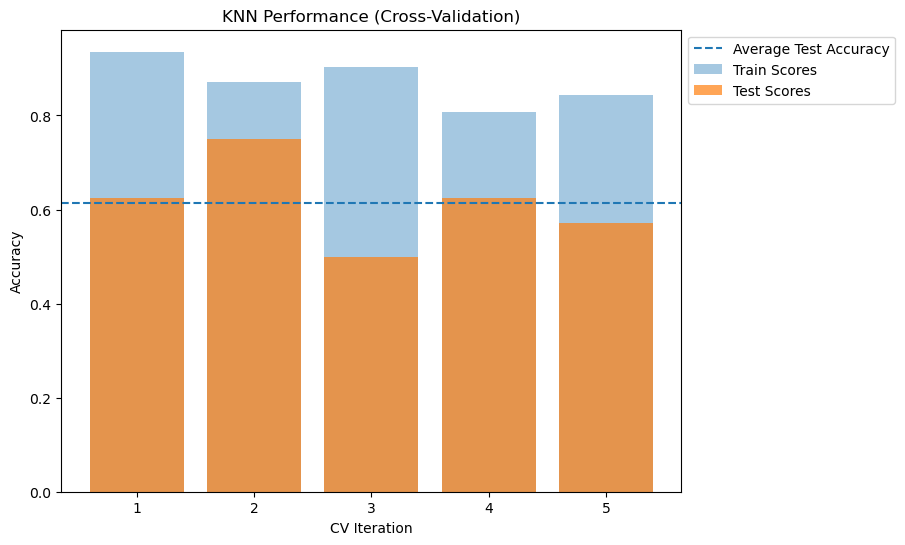

In [60]:
plt.figure(figsize=[8, 6])
plt.bar(np.arange(1, 6), results['train_score'], alpha = 0.4, label = 'Train Scores')
plt.bar(np.arange(1, 6), results['test_score'], alpha = 0.7, label = 'Test Scores')
plt.title("KNN Performance (Cross-Validation)")
plt.axhline(knn_score, linestyle='--', label='Average Test Accuracy')
plt.xlabel("CV Iteration")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('KNN_cv.png')
plt.show()

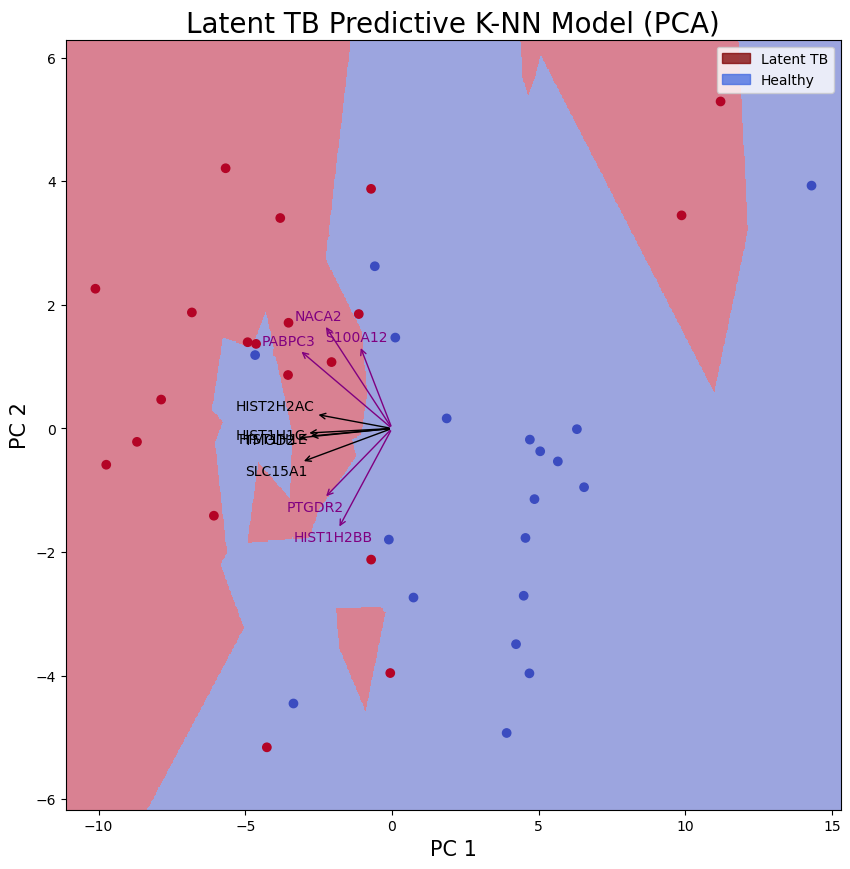

In [69]:
pca = PCA(n_components = 2)
pca.fit(tb_scaled)
pcs = pca.transform(tb_scaled)
X = pcs
h = .02  # step size in the mesh

knn = KNeighborsClassifier(n_neighbors=2)
knn_model = knn.fit(X, labels)


y = [0 if x == 'Healthy' else 1 for x in labels]
# predict the classification probabilities on a grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, zorder=2, cmap='coolwarm')
z = Z.reshape(xx.shape)
z = (z == 'Healthy').astype(int)

red_patch = mpatches.Patch(color='maroon', label='Latent TB',
                           alpha=0.75)
blue_patch = mpatches.Patch(color='royalblue', label='Healthy',
                            alpha=0.75)
plt.legend(handles=[red_patch, blue_patch])
plt.pcolormesh(xx, yy, z, cmap='coolwarm_r', alpha = 0.5)

plt.xlabel("PC 1", fontsize = 15)
plt.ylabel("PC 2", fontsize = 15)
plt.title("Latent TB Predictive K-NN Model (PCA)", fontsize=20)

# Getting top 5 genes
top_genes_idx = np.argsort(np.abs(pc1_weighted_loading))[-5:]
pc1_top_genes = []
for gene_id in top_genes_idx:
    pc1_top_genes.append(gene_names[gene_id])
    # start at 0,0 (middle)
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='black'), color='black') # add direction
    
# Repeating for pc2
pc2_loading = tb_pca.components_[1, :].T
pc2_weighted_loading = pc2_loading * tb_pca.explained_variance_[1]
top_genes_idx = np.argsort(np.abs(pc2_weighted_loading))[-5:]
pc2_top_genes = []
for gene_id in top_genes_idx:
    pc2_top_genes.append(gene_names[gene_id])
    ax.annotate(text = gene_names[gene_id], # add gene name
                xy = [0, 0],
                xytext = [tb_pca.components_.T[gene_id, 0] * tb_pca.explained_variance_[0], 
                          tb_pca.components_.T[gene_id, 1] * tb_pca.explained_variance_[1]],
                arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9, color='purple'), color='purple') # add direction
#plt.savefig('KNN_pca.png')
plt.show()

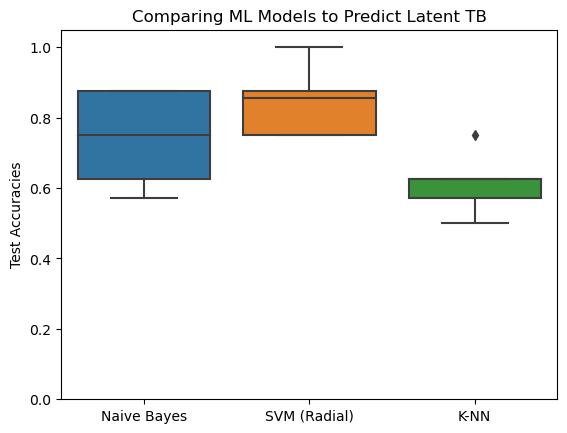

In [62]:
# Comparing all 3 models performances:

sns.boxplot(data = model_results_df)
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracies")
plt.xticks(np.arange(0, 3), ['Naive Bayes', 'SVM (Radial)', 'K-NN'])
plt.title("Comparing ML Models to Predict Latent TB")
#plt.savefig('model_comparisons.png')

**Summary**

Comparing the three different model's predictive abilities given the samples, it is apparent that SVM performed the best. Looking individually at cross-validation results, we see that it has the least tendency to overtrain since the training and test scores were similar. K-NN with 2 neighbors performed the worst, and showed most tendency to over-train. Given the small sample size, I expected K-NN to outperform Naive Bayes and SVM, but it did the worst across the board. Using the PCA plot to observe the decision boundaries, it becomes a little more clear why SVM did the best. Naive Bayes is a linear model and the simple delineation actually works pretty well for most sample points when only considering the differentially expressed genes. SVM's radial kernel adds just a bit more complexity to the decision boundary which actually doesn't 'trust' its trainig data as strictly (see the PCA plot where SVM's boundaries actually misclassify 4 Healthy samples, whereas Naive Bayes only misses 3). However in the context of predicting new cases, this helped SVM since it was likely picking up more of the 'true' signal among the genes by focusing on the support vectors. Finally K-NN, despite having the most complexity in terms of decision boundary, actually did the worst for the same reason as Naive Bayes but to a more extreme extent. It was not picking up a signal among the data values, and just relying on neighbors threw off many TB samples that were close to Healthy ones. 

Ultimately from this small case study, I observe that SVM models may be the most fruitful in terms of actually being predictive model. The 96 selected genes also seemd to perform decently well at differentiating samples by their log2 expressions, with an accuracy score of 84%. Moreover, models such as K-NN may not be appropriate for latent TB predictions since Healthy and non-Healthy samples can often be close together but still have differentiating factors other than distance. 

There are many limitations to this study, and I would treat it as a good starting point to build a stronger model by expanding the small sample size beyond 39. Using the list of 96 differentially expressed genes also is a step that should be taken to reduce the computational load of training models and also reduce the curse of dimensionality. The models I trained where only hyperpramater trained a little to find some optimal priors, but mostly kept at defaults. 